In [1]:
import numpy as np
import xarray as xr
from rasterio import transform

from lausanne_greening_scenarios.scenarios import utils as scenario_utils

In [2]:
agglom_lulc_filepath = '../data/processed/agglom-lulc.tif'
biophysical_table_filepath = '../data/processed/biophysical-table.csv'
shade_threshold = 0.75
num_scenario_runs = 10
change_prop_step = 0.1

In [3]:
scenario_runs = range(num_scenario_runs)
change_props = np.arange(0, 1 + change_prop_step, change_prop_step)

In [4]:
sg = scenario_utils.ScenarioGenerator(agglom_lulc_filepath, biophysical_table_filepath)

In [5]:
scenario_arr = np.array([[
    sg.generate_lulc_arr(shade_threshold, change_prop)
    for scenario_run in scenario_runs
] for change_prop in change_props])

In [6]:
rows = np.arange(sg.lulc_meta['height'])
cols = np.arange(sg.lulc_meta['width'])
lulc_transform = sg.lulc_meta['transform']
xs, _ = transform.xy(lulc_transform, cols, cols)
_, ys = transform.xy(lulc_transform, rows, rows)

# update the raster meta so that it can be encoded as netcdf attributes
attrs = sg.lulc_meta.copy()
attrs.update(crs=f'epsg:{attrs["crs"].to_epsg()}',
             transform=attrs['transform'].to_gdal())
scenario_lulc_da = xr.DataArray(scenario_arr,
                           dims=('change_prop',
                                 'scenario_run', 'y', 'x'),
                           coords={
                               'change_prop': change_props,
                               'scenario_run': scenario_runs,
                               'y': ys,
                               'x': xs
                           },
                           attrs=attrs)

In [7]:
import json
import tempfile
from os import path

import dask
import invest_ucm_calibration as iuc
import rasterio as rio
import xarray as xr

from lausanne_greening_scenarios.invest import utils as invest_utils

In [8]:
t_da_filepath = '../data/processed/tair-ucm.nc'
ref_et_da_filepath = '../data/interim/invest/ref-et.nc'
calibrated_params_filepath = '../data/interim/invest/calibrated-params.json'

In [9]:
t_da = xr.open_dataarray(t_da_filepath)
t_ref = t_da.min(dim=['x', 'y'])
uhi_max = t_da.max(dim=['x', 'y']) - t_ref
max_uhi_date = t_da.isel(time=uhi_max.argmax())['time'].dt.strftime('%Y-%m-%d').item()
t_da = t_da.sel(time=max_uhi_date)
t_ref = t_da.min().item()
uhi_max = t_da.max().item() - t_ref

ref_et_da = xr.open_dataarray(ref_et_da_filepath).sel(time=max_uhi_date)
tmp_dir = tempfile.mkdtemp()
ref_et_raster_filepath = invest_utils.dump_ref_et_raster(
    ref_et_da, max_uhi_date, tmp_dir, invest_utils.get_da_rio_meta(ref_et_da))

In [10]:
with open(calibrated_params_filepath) as src:
    ucm_params = json.load(src)

In [11]:
from affine import Affine

rio_meta = scenario_lulc_da.attrs.copy()
rio_meta['transform'] = Affine.from_gdal(*rio_meta['transform'])

def _t_from_lulc(lulc_arr):
    with tempfile.TemporaryDirectory() as tmp_dir:
        lulc_raster_filepath = path.join(tmp_dir, 'lulc.tif')
        with rio.open(lulc_raster_filepath, 'w', **rio_meta) as dst:
            dst.write(lulc_arr, 1)

        ucm_wrapper = iuc.UCMWrapper(lulc_raster_filepath,
                                     biophysical_table_filepath,
                                     'factors',
                                     ref_et_raster_filepath,
                                     t_ref,
                                     uhi_max,
                                     extra_ucm_args=ucm_params)
        return ucm_wrapper.predict_t_arr(0)

In [12]:
stacked_da = scenario_lulc_da.where((scenario_lulc_da.change_prop>0) & (scenario_lulc_da.change_prop<1), drop=True).stack(scenario=['change_prop', 'scenario_run']).transpose('scenario', 'y', 'x').astype(scenario_lulc_da.dtype)

In [13]:
%%time
pred_delayed = [dask.delayed(_t_from_lulc)(_scenario_lulc_da) for (scenario_run, change_prop), _scenario_lulc_da in stacked_da.groupby('scenario')]
# da = xr.DataArray(list(dask.compute(*pred_delayed, scheduler='processes')), stacked_da.coords)
dims = ['scenario', 'y', 'x']
da = xr.DataArray(list(dask.compute(*pred_delayed, scheduler='processes')), dims=dims, coords={dim: stacked_da.coords[dim] for dim in dims})
da = da.where(da > 0, np.nan)

CPU times: user 9.16 s, sys: 2.84 s, total: 12 s
Wall time: 14min 37s


In [20]:
scenario_T_da = da.unstack(dim='scenario').transpose('change_prop', 'scenario_run', 'y', 'x')

In [23]:
scenario_T_avg_da = scenario_T_da.mean(dim=['x', 'y'], skipna=True)
scenario_T_avg_da.name = 'T_avg'
df = scenario_T_avg_da.to_dataframe().reset_index()

In [25]:
import seaborn as sns

<AxesSubplot:xlabel='change_prop', ylabel='T_avg'>

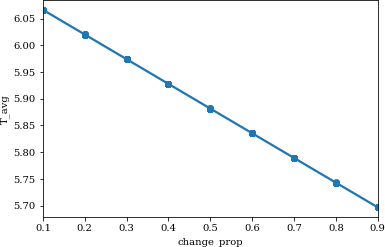

In [28]:
sns.regplot(x='change_prop', y='T_avg', data=df.dropna())

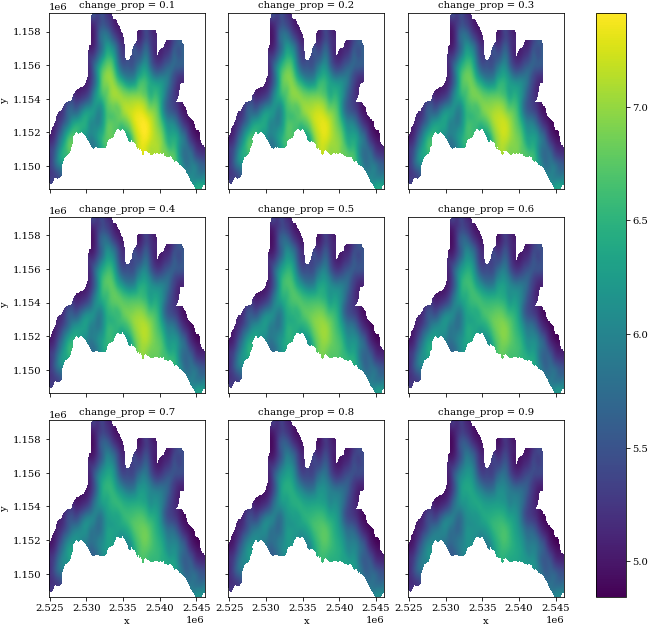

In [34]:
scenario_T_da.mean(dim=['scenario_run']).plot(col='change_prop', col_wrap=3)

In [14]:
stacked_da

<xarray.DataArray (scenario: 90, y: 1052, x: 2131)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * y             (y) float64 1.159e+06 1.159e+06 ... 1.149e+06 1.149e+06
  * x             (x) float64 2.525e+06 2.525e+06 ... 2.546e+06 2.546e+06
  * scenario      (scenario) MultiIndex
  - scenario_run  (scenario) int64 0 0 0 0 0 0 0 0 0 1 1 ... 8 9 9 9 9 9 9 9 9 9
  - change_prop   (scenario) float64 0.1 0.2 0.3 0.4 0.5 ... 0.5 0.6 0.7 0.8 0.9

## No dask

In [12]:
stacked_da = scenario_lulc_da.where((scenario_lulc_da.change_prop>0.3) & (scenario_lulc_da.change_prop<0.5), drop=True).stack(scenario=['scenario_run', 'change_prop']).transpose('scenario', 'y', 'x').astype(scenario_lulc_da.dtype)

In [14]:
%%time
da = stacked_da.groupby('scenario').apply(_t_from_lulc)

CPU times: user 2min 13s, sys: 1.19 s, total: 2min 14s
Wall time: 2min 15s


In [13]:
# stacked_da = scenario_lulc_da.where((scenario_lulc_da.change_prop>0.3) & (scenario_lulc_da.change_prop<0.5), drop=True).stack(scenario=['scenario_run', 'change_prop']).transpose('scenario', 'y', 'x').chunk({'scenario': 1}).astype(scenario_lulc_da.dtype)
stacked_da = stacked_da.chunk({'scenario': 1})

In [17]:
%%time
da = xr.apply_ufunc(_t_from_lulc, stacked_da, input_core_dims=[['y', 'x']], output_core_dims=[['y', 'x']], dask='allowed', vectorize=True)

CPU times: user 2min 7s, sys: 903 ms, total: 2min 8s
Wall time: 2min 10s


In [18]:
%%time
with dask.config.set(scheduler='processes', n_workers=4):
    da = xr.apply_ufunc(_t_from_lulc, stacked_da, input_core_dims=[['y', 'x']], output_core_dims=[['y', 'x']], dask='allowed', vectorize=True)

CPU times: user 2min 7s, sys: 1.26 s, total: 2min 8s
Wall time: 2min 11s


In [14]:
from dask import distributed

In [27]:
import numpy as np
import xarray as xr
import pandas as pd

def special_mean(x, drop_min=False):
    s = np.sum(x)
    n = len(x)
    if drop_min:
        s = s - x.min()
    n -= 1
    return s/n

times = pd.date_range('2019-01-01', '2019-01-10', name='time')

data = xr.DataArray(np.random.rand(10, 80, 80), dims=["time", "y", "x"], coords={'time': times})
data = data.chunk({'time':10, 'x':1, 'y':1})

res = xr.apply_ufunc(special_mean, data, input_core_dims=[["time"]], kwargs={'drop_min': True}, dask = 'allowed', vectorize = True)

In [22]:
%%time
da = xr.apply_ufunc(_t_from_lulc, stacked_da, input_core_dims=[['y', 'x']], output_core_dims=[['y', 'x']], dask='allowed', vectorize=True)

distributed.nanny - WARNING - Restarting worker


distributed.nanny - WARNING - Restarting worker


distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker


In [33]:
client = distributed.Client()

In [30]:
dims = ['scenario', 'y', 'x']

In [ ]:
%%time
pred_delayed = [dask.delayed(_t_from_lulc)(_scenario_lulc_da) for (scenario_run, change_prop), _scenario_lulc_da in stacked_da.groupby('scenario')]
# da = xr.DataArray(list(dask.compute(*pred_delayed, scheduler='processes')), stacked_da.coords)
da = xr.DataArray(list(dask.compute(*pred_delayed, scheduler='processes')), dims=dims, coords={dim: stacked_da.coords[dim] for dim in dims})
da = da.where(da > 0, np.nan)

In [15]:
%%time
da = stacked_da.groupby('scenario').apply(_t_from_lulc)

CPU times: user 4min 36s, sys: 2.22 s, total: 4min 38s
Wall time: 4min 40s


In [16]:
da

<xarray.DataArray (scenario: 9, y: 1052, x: 2131)>
array([[[-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        ...,
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38]],

       [[-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
...
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38]],

       [[-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        ...,
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38]]])
Coordinates:
  * y             (y) float64 1.159e+06 1.159e+06 ... 1.149e+06 1.149e+06
  * x             (x) float64 2.525e+06 2.525e+06 ... 2.546e+06 2.546e+06
  * scenario      (scenario) MultiIndex
  - scenario_run  (scenario) int64 0 0 0 1 1 1 2 2 2
  - change_prop   (scenario) float64 0.3 0.4 0.5 0.3 0.4 0.5 0.3 0.4 0.5

In [26]:
gb = stacked_da.groupby('scenario')

In [ ]:
gb.apply

In [21]:
stacked_da = scenario_lulc_da.where((scenario_lulc_da.change_prop>0.3) & (scenario_lulc_da.change_prop<0.6), drop=True).stack(scenario=['scenario_run', 'change_prop']).transpose('scenario', 'y', 'x').astype(scenario_lulc_da.dtype)

In [22]:
dims = ['scenario', 'y', 'x']

In [23]:
%%time
da = xr.DataArray([_t_from_lulc(_scenario_lulc_da) for (scenario_run, change_prop), _scenario_lulc_da in stacked_da.groupby('scenario')], dims=dims, coords={dim: stacked_da.coords[dim] for dim in dims})    

KeyboardInterrupt: 

In [17]:
%%time
pred_delayed = [dask.delayed(_t_from_lulc)(_scenario_lulc_da) for (scenario_run, change_prop), _scenario_lulc_da in stacked_da.groupby('scenario')]
# da = xr.DataArray(list(dask.compute(*pred_delayed, scheduler='processes')), stacked_da.coords)
da = xr.DataArray(list(dask.compute(*pred_delayed, scheduler='processes')), dims=dims, coords={dim: stacked_da.coords[dim] for dim in dims})
da = da.where(da > 0, np.nan)

ValueError: the array's dtype 'float64' does not match the file's dtype 'uint16'

Traceback
---------
  File "/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/dask/local.py", line 222, in execute_task
    result = _execute_task(task, data)
  File "/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/dask/core.py", line 121, in _execute_task
    return func(*(_execute_task(a, cache) for a in args))
  File "<ipython-input-14-31741da2b725>", line 10, in _t_from_lulc
  File "rasterio/_io.pyx", line 1365, in rasterio._io.DatasetWriterBase.write


In [11]:
# for dim in set(scenario_lulc_da.dims).difference(set(['x', 'y']))
# stacked_da = scenario_lulc_da.where((scenario_lulc_da.change_prop>0) & (scenario_lulc_da.change_prop<1), drop=True).stack(scenario=['scenario_run', 'change_prop']).transpose('scenario', 'y', 'x').chunk({'scenario': 1})
stacked_da = scenario_lulc_da.where((scenario_lulc_da.change_prop>0.3) & (scenario_lulc_da.change_prop<0.7), drop=True).stack(scenario=['scenario_run', 'change_prop']).transpose('scenario', 'y', 'x').chunk({'scenario': 1}).astype(scenario_lulc_da.dtype)

In [ ]:
da = xr.apply_ufunc(_t_from_lulc, stacked_da.groupby('scenario'), dask='allowed')

In [13]:
from dask import diagnostics

with diagnostics.ProgressBar():
    da = xr.apply_ufunc(_t_from_lulc, stacked_da.groupby('scenario'), dask='allowed')

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.1s

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.1s

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.1s

KeyboardInterrupt: 

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.1s

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.1s

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.1s

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.1s

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.1s

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.1s

KeyboardInterrupt: 

KeyboardInterrupt: 

In [14]:
da

NameError: name 'da' is not defined

In [ ]:
xr.map_blocks

In [44]:
stacked_da.data

,Array,Chunk
Bytes,717.38 MB,17.93 MB
Shape,"(40, 1052, 2131)","(1, 1052, 2131)"
Count,41 Tasks,40 Chunks
Type,float64,numpy.ndarray


In [46]:
result = stacked_da.data.map_blocks(_t_from_lulc).compute()

(1, 1, 1)


ValueError: `dtype` inference failed in `map_blocks`.

Please specify the dtype explicitly using the `dtype` kwarg.

Original error is below:
------------------------
TypeError("invalid driver: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 2131, 'height': 1052, 'count': 1, 'crs': 'epsg:2056', 'transform': Affine(10.0, 0.0, 2524843.0,\n       0.0, -10.0, 1159128.0)}")

Traceback:
---------
  File "/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/dask/array/core.py", line 342, in apply_infer_dtype
    o = func(*args, **kwargs)
  File "<ipython-input-45-13d90f2c4336>", line 10, in _t_from_lulc
    with rio.open(lulc_raster_filepath, 'w', rio_meta) as dst:
  File "/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/rasterio/env.py", line 433, in wrapper
    return f(*args, **kwds)
  File "/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/rasterio/__init__.py", line 159, in open
    raise TypeError("invalid driver: {0!r}".format(driver))


In [ ]:
xr.apply_ufunc(_t_from_lulc, dask='allowed')

In [ ]:
pred_delayed = [dask.delayed(sw._t_from_lulc)(_scenario_lulc_da) for (scenario_run, change_prop), _scenario_lulc_da in stacked_da.groupby('scenario')]
# da = xr.DataArray(list(dask.compute(*pred_delayed, scheduler='processes')), stacked_da.coords)
dims = ['scenario', 'y', 'x']
da = xr.DataArray(list(dask.compute(*pred_delayed, scheduler='processes')), dims=dims, coords={dim: stacked_da.coords[dim] for dim in dims})
da = da.where(da > 0, np.nan)

In [ ]:
class _ScenarioWrapper(scenario_utils.ScenarioWrapper):
    def _t_from_lulc(self, lulc_arr):
        with tempfile.TemporaryDirectory() as tmp_dir:
            lulc_raster_filepath = path.join(tmp_dir, 'lulc.tif')
            with rio.open(lulc_raster_filepath, 'w', **self.rio_meta) as dst:
                dst.write(lulc_arr, 1)

            ucm_wrapper = iuc.UCMWrapper(lulc_raster_filepath,
                                         self.biophysical_table_filepath,
                                         'factors',
                                         self.ref_et_raster_filepath,
                                         self.t_ref,
                                         self.uhi_max,
                                         extra_ucm_args=self.ucm_params)
            return ucm_wrapper.predict_t_arr(0)

In [ ]:

# sw = _ScenarioWrapper(_scenario_lulc_da, t_da.sel(time=max_uhi_date), biophysical_table_filepath, ref_et_raster_filepath, ucm_params)

MemoryError: Unable to allocate 1.50 GiB for an array with shape (1052, 2131, 10, 9) and data type float64

In [122]:
stacked_da.chunks

((1052,),
 (2131,),
 (1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1))

In [104]:
%%time
pred_delayed = [dask.delayed(sw._t_from_lulc)(_scenario_lulc_da) for (scenario_run, change_prop), _scenario_lulc_da in stacked_da.groupby('scenario')]
# da = xr.DataArray(list(dask.compute(*pred_delayed, scheduler='processes')), stacked_da.coords)
dims = ['scenario', 'y', 'x']
da = xr.DataArray(list(dask.compute(*pred_delayed, scheduler='processes')), dims=dims, coords={dim: stacked_da.coords[dim] for dim in dims})
da = da.where(da > 0, np.nan)

MemoryError: 

In [111]:
results = list(dask.compute(*pred_delayed, scheduler='processes'))

MemoryError: 

90

In [105]:
scenario_T_da = da.unstack(dim='scenario')

In [106]:
scenario_T_avg_da = scenario_T_da.mean(dim=['x', 'y'], skipna=True)
scenario_T_avg_da.name = 'T_avg'
df = scenario_T_avg_da.to_dataframe().reset_index()
sns.lineplot(x='change_prop', y='T_avg', data=df.dropna())

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [107]:
df = scenario_T_avg_da.to_dataframe().reset_index()

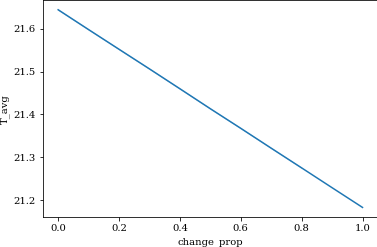

In [108]:
ax = sns.lineplot(x='change_prop', y='T_avg', data=df.dropna())

In [101]:
ax.lines

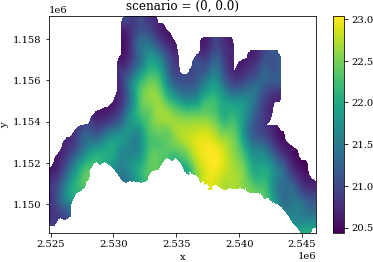

In [29]:
da.where(da > 0, np.nan).isel(scenario=0).plot()

In [27]:
da

<xarray.DataArray (scenario: 4, y: 1052, x: 2131)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * scenario      (scenario) MultiIndex
  - scenario_run  (scenario) int64 0 0 0 0
  - change_prop   (scenario) float64 0.0 0.1 0.2 0.3
  * y             (y) float64 1.159e+06 1.159e+06 ... 1.149e+06 1.149e+06
  * x             (x) float64 2.525e+06 2.525e+06 ... 2.546e+06 2.546e+06

In [44]:
%%time
_ = gb.map(sw._t_from_lulc)

CPU times: user 2min 10s, sys: 1.09 s, total: 2min 11s
Wall time: 2min 13s


In [45]:
%%time
da = xr.apply_ufunc(sw._t_from_lulc, gb, dask='parallelized')

CPU times: user 2min 5s, sys: 1.14 s, total: 2min 7s
Wall time: 2min 12s


In [42]:
result

[array([[-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        ...,
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38]]),
 array([[-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e

In [ ]:
da.where

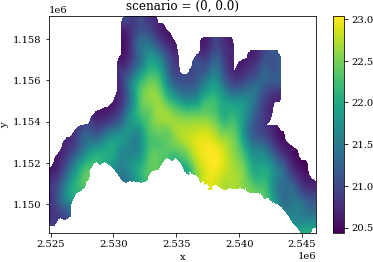

In [29]:
da.where(da > 0, np.nan).isel(scenario=0).plot()

In [75]:
# TODO: try with a shorter gb
da = xr.apply_ufunc(sw._t_from_lulc, gb, dask='allowed')

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
dir(gb)

In [56]:
da = _t_from_lulc(sw, _scenario_lulc_da)

In [ ]:
scenario_lulc_da.stack(scenario=['scenario_run', 'change_prop']).groupby('scenario').apply_ufunc

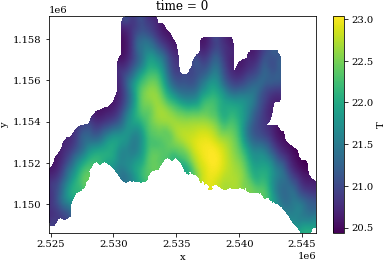

In [58]:
da.plot()

In [44]:
_scenario_lulc_da

<xarray.DataArray (y: 1052, x: 2131)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * y         (y) float64 1.159e+06 1.159e+06 1.159e+06 ... 1.149e+06 1.149e+06
  * x         (x) float64 2.525e+06 2.525e+06 2.525e+06 ... 2.546e+06 2.546e+06
    scenario  object (0, 0.0)
Attributes:
    driver:     GTiff
    dtype:      uint16
    nodata:     0.0
    width:      2131
    height:     1052
    count:      1
    crs:        epsg:2056
    transform:  (2524843.0, 10.0, 0.0, 1159128.0, 0.0, -10.0)

In [34]:
scenario_ds = xr.Dataset({'lulc': scenario_lulc_da})

In [37]:
scenario_ds.groupby('change_prop', 'scenario_run'])

TypeError: `group` must be an xarray.DataArray or the name of an xarray variable or dimension

In [ ]:
def t_from_lulc(scenario_lulc_da):
    with 


In [32]:
def compute_t_da(self):
    
